![terrainbento logo](../images/terrainbento_logo.png)

# terrainbento model BasicRt steady-state solution

This model shows example usage of the BasicRt model from the TerrainBento package.

BasicRt modifies Basic by allowing for two lithologies:

$\frac{\partial \eta}{\partial t} = - K(\eta,\eta_C) A^{1/2}S + D\nabla^2 \eta$

$K(\eta, \eta_C ) = w K_1 + (1 - w) K_2$

$w = \frac{1}{1+\exp \left( -\frac{(\eta -\eta_C )}{W_c}\right)}$

where $W_c$ is the contact-zone width.

Refer to [REF MANUSCRIPT] for the definition of all symbols. 

This notebook (a) shows the initialization and running of this model, (b) saves a NetCDF file of the topography, which we will use to make an oblique Paraview image of the landscape, and (c) creates a slope-area plot at steady state.

In [1]:
# import required modules
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({"font.size": 20})
%matplotlib inline

from landlab import imshow_grid
from landlab.io.netcdf import write_netcdf

from terrainbento import BasicRt

In [2]:
# create the parameter dictionary needed to instantiate the model 
# all parameters used are specified in this notebook block

params = {# these three parameters are required by all models
          "dt" : 10, # years
          "output_interval": 1e4, # years
          "run_duration": 1e7, # years
          # these parameters are needed to specify the details of the model grid
          "number_of_node_rows" : 100,
          "number_of_node_columns" : 160,
          "node_spacing" : 10.0, # meters
          "add_random_noise": True, 
          "initial_noise_std": 1.,
          "random_seed": 4897, # set to initialize the topography with reproducible random noise
          # these parameter control geomorphic processes
          "water_erodability~lower" : 0.001, # years^-1
          "water_erodability~upper" : 0.01, # years^-1
          "m_sp" : 0.5, # unitless
          "n_sp" : 1.0, # unitless
          "regolith_transport_parameter" : 0.1, # meters^2/year
          "lithology_contact_elevation__file_name" : os.path.join("..", "input_data", "contact_elevation.txt"),
          "contact_zone__width" : 1.0, # meters
          # these parameters control model boundary conditions
          "BoundaryHandlers": "NotCoreNodeBaselevelHandler",
          "NotCoreNodeBaselevelHandler": {"modify_core_nodes": True, "lowering_rate": -0.001} , # meters/year
          # these parameter control how model output is written
          "save_first_timestep": True,
          "output_filename": "output_netcdfs/basicRt.",
         }

In [3]:
# we can use an output writer to run until the model reaches steady state. 
class run_to_steady(object):
    def __init__(self, model):
        self.model = model
        self.last_z = self.model.z.copy()
        self.tolerance = 0.0001
    def run_one_step(self):
        if model.model_time > 0:
            diff = self.model.z - self.last_z
            if max(abs(diff[model.grid.core_nodes])) <= self.tolerance: #1mm
                model.total_run_duration = model._model_time
                print("Model reached steady state in " + str(model._model_time) + " time units\n")
            else:
                self.last_z = self.model.z.copy()
                if model._model_time <= self.model.total_run_duration - self.model.output_interval:
                    self.model.total_run_duration += self.model.output_interval

In [4]:
# initialize the model by passing the parameter dictionary
model = BasicRt(params=params, OutputWriters=run_to_steady)

# to run the model as specified by the parameters we execute the following line:
model.run(output_fields="topographic__elevation")

Model reached steady state in 120000.0 time units



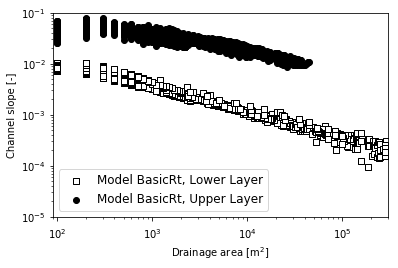

In [5]:
# MAKE SLOPE-AREA PLOT

# plot nodes that are not on the boundary or adjacent to it
upper_plotting_nodes = ((model.grid.node_x > params["node_spacing"])&
                        (model.grid.node_x < params["node_spacing"]*(params["number_of_node_columns"]-2))&
                        (model.grid.node_y > 500.0)&
                        (model.grid.node_y < params["node_spacing"]*(params["number_of_node_rows"]-2)))

lower_plotting_nodes = ((model.grid.node_x > params["node_spacing"])&
                        (model.grid.node_x < params["node_spacing"]*(params["number_of_node_columns"]-2))&
                        (model.grid.node_y > params["node_spacing"])&
                        (model.grid.node_y < 500.0))


# assign area_array and slope_array for ROCK
area_array_upper = model.grid.at_node["drainage_area"][upper_plotting_nodes]
slope_array_upper = model.grid.at_node["topographic__steepest_slope"][upper_plotting_nodes]
# assign area_array and slope_array for TILL
area_array_lower = model.grid.at_node["drainage_area"][lower_plotting_nodes]
slope_array_lower = model.grid.at_node["topographic__steepest_slope"][lower_plotting_nodes]

# instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
slope_area = plt.subplot()

#plot the data for ROCK
slope_area.scatter(area_array_lower, slope_array_lower, marker="s", edgecolor="0", color="1", 
                   label = "Model BasicRt, Lower Layer")

#plot the data for TILL
slope_area.scatter(area_array_upper, slope_array_upper, color="k", 
                   label = "Model BasicRt, Upper Layer") 

#make axes log and set limits
slope_area.set_xscale("log")
slope_area.set_yscale("log")

slope_area.set_xlim(9*10**1, 3*10**5)
slope_area.set_ylim(1e-5, 1e-1)

#set x and y labels
slope_area.set_xlabel(r"Drainage area [m$^2$]")
slope_area.set_ylabel("Channel slope [-]")
slope_area.legend(scatterpoints=1,prop={"size":12})
slope_area.tick_params(axis="x", which="major", pad=7)

# save out an output figure
output_figure = os.path.join("output_figures/maintext_rock_till_slope_area.eps")
fig.savefig(output_figure, bbox_inches="tight", dpi=1000) # save figure

In [6]:
# Save stack of all netcdfs for Paraview to use.
model.save_to_xarray_dataset(filename="output_netcdfs/basicRt.nc", 
                             time_unit="years", 
                             reference_time="model start", 
                             space_unit="meters")
        
# remove temporary netcdfs
model.remove_output_netcdfs()

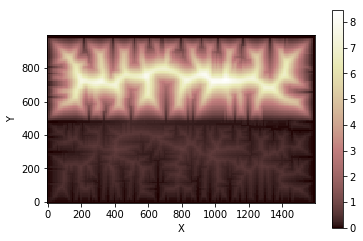

In [7]:
# make a plot of the final steady state topography
imshow_grid(model.grid, "topographic__elevation")

## Next Steps

- We recommend you review the [terrainbento manuscript](). **Link not yet active**

- There are three additional introductory tutorials: 

    1) [Introduction terrainbento](http://localhost:8888/notebooks/example_usage/Introduction_to_terrainbento.ipynb) 
    
    2) [Introduction to boundary conditions in terrainbento](http://localhost:8888/notebooks/example_usage/introduction_to_boundary_conditions.ipynb)
    
    3) **This Notebook**: [Introduction to OutputWriters in terrainbento](http://localhost:8888/notebooks/example_usage/introduction_to_output_writers.ipynb). 
    
    
- Five examples of steady state behavior in coupled process models can be found in the following notebooks:

    1) [Basic](http://localhost:8888/notebooks/coupled_process_elements/model_000_COUPLED_steady_solution.ipynb) the simplest landscape evolution model in the terrainbento package.

    2) [BasicVm](http://localhost:8888/notebooks/coupled_process_elements/model_001_COUPLED_steady_solution.ipynb) which permits the drainage area exponent to change.

    3) [BasicCh](http://localhost:8888/notebooks/coupled_process_elements/model_040_COUPLED_steady_solution.ipynb) which uses a non-linear hillslope erosion and transport law.

    4) [BasicVs](http://localhost:8888/notebooks/coupled_process_elements/model_200_COUPLED_steady_solution.ipynb) which uses variable source area hydrology.

    5) [BasisRt](http://localhost:8888/notebooks/coupled_process_elements/model_800_COUPLED_steady_solution.ipynb) which allows for two lithologies with different K values.